<a href="https://colab.research.google.com/github/robert-marik/apl-slidy/blob/master/Krivkovy_integral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Křivkový integrál

Budeme se zajímat o tok vektorového pole křivkou. Může jít například o tok tepla. Pokud je křivka uzavřená, vypočteme celkové teplo, které proteče do oblasti obepnuté touto křivkou. Podobně je možné modelovat difuzní tok a zjišťovat, jaké množství difundující látky se dostane do oblasti. Znaménková konvence pro kladně orientované křivky (při obíhání ve směru rostoucího parametru je oblast obepnutá křivkou po levé ruce) je taková, že tok ven je kladný a tok dovnitř záporný. 

In [2]:
import numpy                     # knihovna na numerické výpočty (goniomerické funkce, gradient, 2D mřížka a dělení intervalu, ...)
import scipy.integrate           # knihovna na technické výpočty (integrál)
import matplotlib.pyplot as plt  # knihovna na kreslení

Definujeme nástroje pro výpočet toku. Pro lepší představu budeme uvažovat teplotní tok, který je záporně vzatým gradientem teploty. Budme uvažovat uzavřenou křivku ve tvaru srdce a vyjde nám tedy tok touto křivkou, tj. bilance mezi přírůstkem a úbytkem tepla (nebo obecně stavové veličiny) uvnitř. Křivka je orientována proti směru hodinových ručiček a kladný tok je tok ven ze srdce. 

Pro jednoduchost použijeme poměrně naivní metodu výpočtu celkového toku křivkou. Hranici si rozdělíme na $N$ dílků podle hodnoty parametru parametrizujícího křivku. Vypočteme tok na každém dílku a sečteme je integrálem za použití Simpsonovy metody. Pro lepší ilustraci si graf takto integrované funkce kreslíme do pravého obrázku. Začátek i konec odpovídá hornímu bodu uprostřed srdce, tj. bodu o souřadnicích $(0,5)$. 

Celkový tok vydělíme obsahem srdce. Tím budeme mít změnu na jednotku obsahu, což odpovídá divergenci. Zejména v případech, pokud je divergence konstantní (teplota dána lineární nebo kvadratickou funkcí) očekáváme shodu tohoto podílu s divergencí.


In [13]:
def teplota (x,y): 
  return 20-x

def krivka(t):                                    # parametrické rovnice křivky ve tvaru srdce
   return [ -16*numpy.sin(t)**3 , 13*numpy.cos(t)-5*numpy.cos(2*t)-2*numpy.cos(3*t)-numpy.cos(4*t)]  

def KRESLI():
    global teplota                                # pouzijeme globalne definovane funkce
    global krivka
    y, x = numpy.mgrid[-20:20:20j, -20:20:20j]    # mrizka pro kresleni gradientu a barevne mapy funkce dvou promennych
    z = teplota(x, y)                             # evaluation of the function on the grid
    grady, gradx = numpy.gradient(z)              # gradient vysky
    vx, vy = -gradx, -grady                       # tok, pole opačné ke gradientu

                                                  # inicializace grafiky, dva grafy vedle sebe
    fig, axes = plt.subplots(1, 2, figsize=(30,12))
    
    ## Vykreslení teploty a toku tepla
    ax=axes[0]                                    # začneme kreslit do prvního grafu
    cmap = plt.get_cmap('hot')                    # nastaveni schema pro barevnou mapu
    output = ax.pcolormesh(x, y, z, cmap=cmap, shading='gouraud') # vykresleni barevne mapy
    plt.colorbar(output, ax=ax)                   # barevný sloupec s hodnotami vedle grafu
    ax.quiver(x, y, vx, vy, color='blue')         # vykreslení toku
    
    ## Vykreslení křivky
    N = 1000                                      # počet dělení intervalu pro parametr t
    t = numpy.linspace(0, 2*numpy.pi, N)          # uzlové body křivky
    ax.plot(krivka(t)[0],krivka(t)[1], color='green', lw=4) # vykreslení křivky
    ax.set_aspect(1)                              # stejné měřítko na obou osách

    ## Výpočet integrálu
    dt = (t[-1] - t[0] ) / N                      # vzdálenost mezi uzlovými body
    h = dt                                        # krok pro výpočet derivace, je také možné derivace počítat analyticky, což by navýšilo přesnost
    I = []                                        # inicializace pole, kam budeme sbírat jednotlivé příspěvky k celkovému toku
    for j in range(len(t)):                       # cyklus přes všechny body, které uvažujeme na křivce
        x, y = krivka(t[j])                       # souřadnice bodu na křivce
        dx, dy = [ ( krivka(t[j]+h)[i] - krivka(t[j]-h)[i] )/ (2*h) for i in (0,1) ]  # derivace krivky v bode pomoci centralni diference
        vx, vy = [ - (teplota(x+h,y)-teplota(x-h,y) ) / (2*h) , - (teplota(x,y+h)-teplota(x,y-h) ) / (2*h) ] # pole kolme ke gradientu vypočtené pomocí centrální diference
        I = I + [ - vy * dx * dt + vx * dy * dt ] # prispevek k integralu

    integral = scipy.integrate.simps(I)

    S = 565.4866776461629                         # obsah srdce podle https://sagecell.sagemath.org/?z=eJxtkEFuwyAQRfeWfIeRsghQEjlO20Ultr5E1UbUkAolxi4mFnD6gh2iNCre_O-Z0X8zEzdobde4LFarFQQuuFZwvOhTK8uicchRTwNmVTQ-GxdNuKukL02bftKqlTCYHk5GTSdfFg5ZzDa7VzIqHSUh-7Lw6d9uT9p-jGrzMouaRFnPcp9kEs9RlEVI7VUO6WRYEgZueCetKQvbKU1txx2raE0GdSP6580VfemkUS0_H5S28tvwM4IjcizBUs8SHw0s5WIgMP4Yi4Q6xo5UsPizfpqt_2tDtphCfDcq_F59pFjRjzxIrQ7LbVjHBwRn3n0JDsPbkPPhCgBXAgqocbTxFJqA4zkirlBS28f57QyRBhfOZYt5B5zi_1l6kq3tDXoAw1vR20M8sbi0NvfkVHy3HOTtfgFhmKo-&lang=sage&interacts=eJyLjgUAARUAuQ==
    podil = integral / S                          # Podíl toku a obsahu množiny. Střední hodnota divergence.
    ax.set_title("Výsledný tok je %s. Podíl toku a obsahu srdce je %s."%(str(integral),str(podil)))

    ax = axes[1]                                  # začneme kreslit do druhého grafu
    ax.plot(I)                                    # vykreslení součinu tečného vektoru ke křivce s kolmým polem na tok, příspěvek k celkovému toku
    ax.set_title("Průběh příspěvků k celkovému toku")

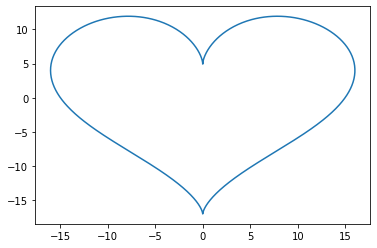

In [25]:
def krivka(t):                                    # parametrické rovnice křivky ve tvaru srdce
   return [ -16*numpy.sin(t)**3 , 13*numpy.cos(t)-5*numpy.cos(2*t)-2*numpy.cos(3*t)-numpy.cos(4*t)] 

def krivka_derivace(t):                           # derivace rovnice křivky ve tvaru srdce
   return [ -16*3*numpy.sin(t)**2*numpy.cos(x) , -13*numpy.sin(t)+5*numpy.sin(2*t)*2+2*numpy.sin(3*t)*3+numpy.sin(4*t)*4]

h = 0.01
t = numpy.linspace(0, 2*numpy.pi, 1000)
x,y = krivka(t)
Fx = 0
Fy = krivka(t)[0]
I = Fy*krivka_derivace(t)[0]
In = scipy.integrate.simps(I,t)
plt.plot(x,y)

# Tok vektorového pole s konstantní divergencí

Využijeme předpřipravené funkce vždy na vektorové pole mající konstantní divergenci. To znamená, že tok zesiluje ve všech místech stejnou intenzitou. Pokud by byla úloha stacionární, podle difuzní rovnice by případné zesilování toku šlo na vrub zdrojům či spotřebičům. Konstantnost divergence poté znamená, že tyto zdroje či spotřebiče jsou rozloženy rovnoměrně v rovině.

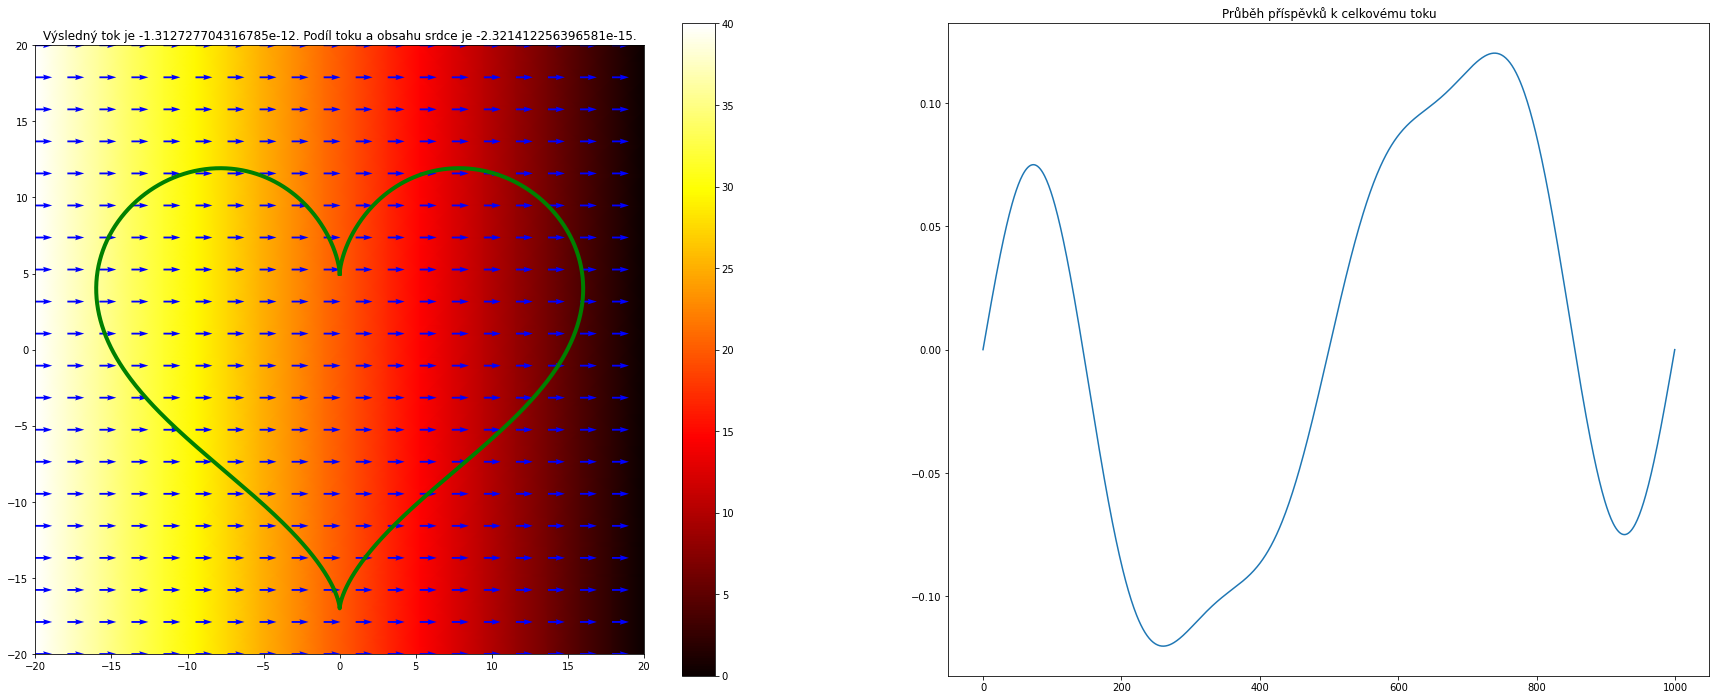

In [ ]:
def teplota (x,y): 
   return 20-x
KRESLI()

Teplota na obrázku výše je dána vztahem $$T(x,y)=20-x.$$ Roste tedy konstantní rychlostí směrem doleva. Teplo teče doprava. Situace je krásně symetrická. Teplo, které na levé straně do srdce vteče, na pravé straně vyteče. Tuto symetrii je možno odhadnout z obrázku toku. Středově symetrická je i křivka vpravo. Divergence vektorového pole popisujícího tok tepla je nulová, $$\nabla \cdot (-\nabla T)=0.$$
Výpočet z definice programem Sage je [zde](https://sagecell.sagemath.org/?z=eJxtj89qhDAQxu-C7xDwsDHo4rptDwWvvkQpMk2yJWj-EKNEn75JxD0snVx-k5lv5psVLL64S5lnRVGgHRgogR6LGimvkNFUOEAzR06PaLRiHfWSZ73HvtrKrm6JD9n2zLY8O16cZfWqBOXIWH1IQ9VjFxpvH2QWKiAh9zzb4t_tTqieA9XvCVoSsE14jxjhLUCe7bG9OZdIvh8bDFiQ3Nk8c1KoyknwXVO1xIino38iVY4GpmfYuRLD4bWTYDCaQP4wQObTYN9F8xXaumg4AK77rep9GTz9WmCCK_cqujLxeCQVTuKkRGVcpxbJraAwDUI5HgZMeOXUaYtfjJRXpt0QTmQLdWfPuTD6CJFORvHm8qv5_gMoX4cO&lang=sage&interacts=eJyLjgUAARUAuQ==), křivka je předepsána, nastavte si požadovanou funkci.

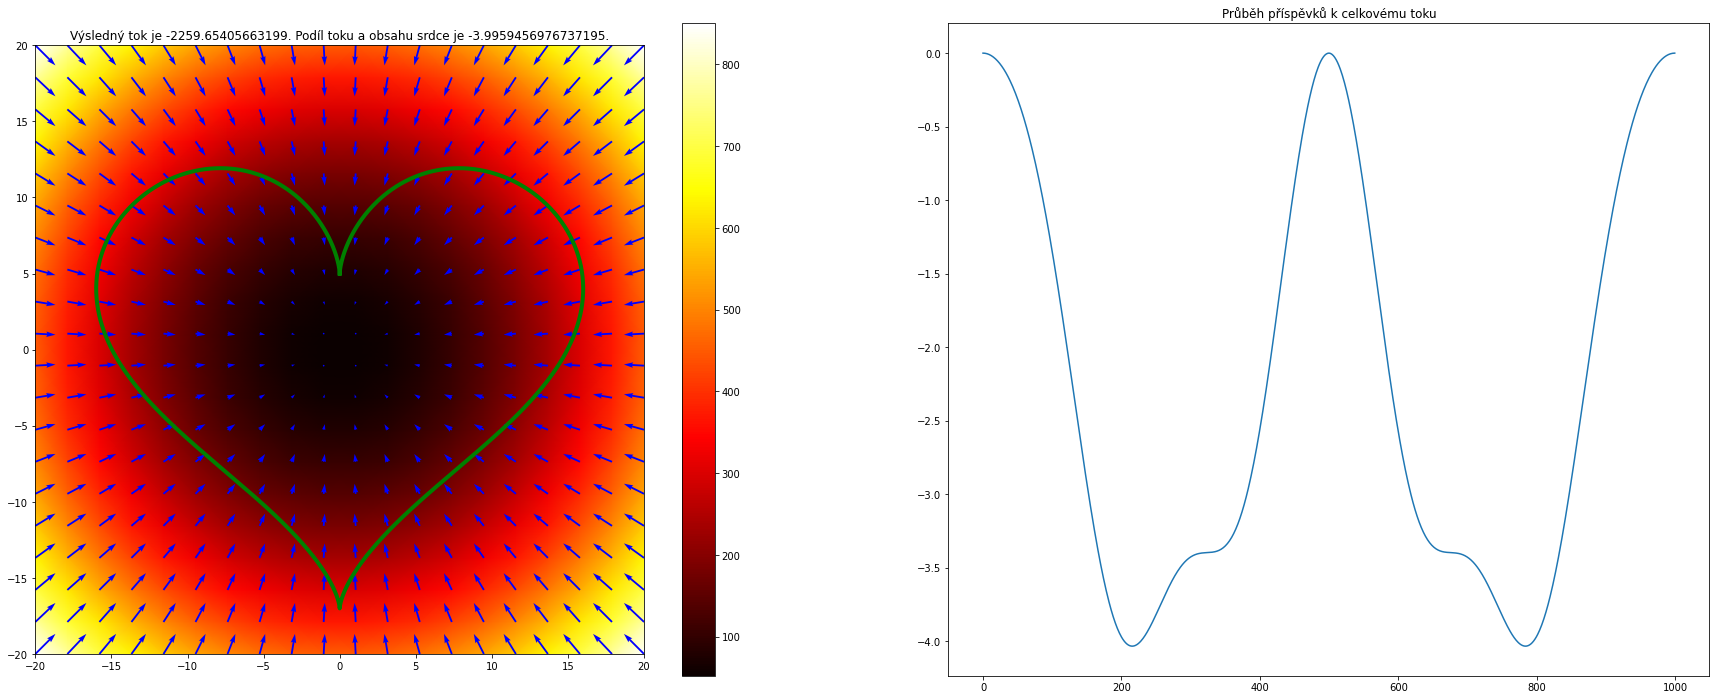

In [ ]:
def teplota (x,y): 
  return (50+(x**2+y**2)) 
KRESLI()

Teplota na obrázku výše je dána vztahem $$T(x,y)=50+x^2+y^2.$$ Roste tedy směrem od středu. Uprostřed je nejnižší teplota (nejtmavší barva) a teplo teče do srdce. Tok je záporný. Divergence vektorového pole popisujícího tok tepla je konstantní záporná, $$\nabla \cdot (-\nabla T)=-4.$$

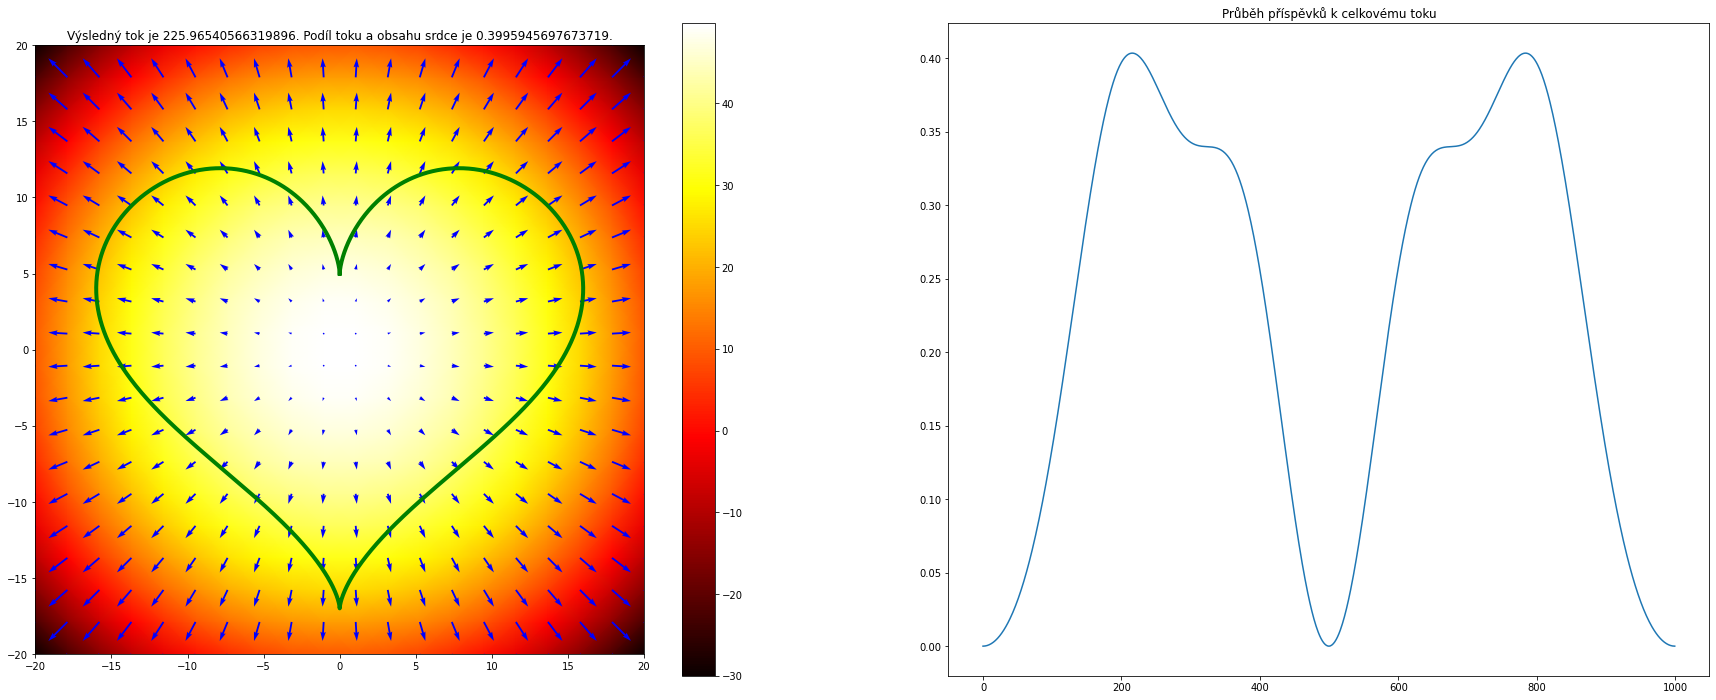

In [ ]:
def teplota (x,y): 
  return 50-(x**2+y**2)*0.1
KRESLI()  

Teplota na obrázku výše je dána vztahem $$T(x,y)=50-\frac {x^2+y^2}{10}.$$ Klesá tedy směrem od středu. Uprostřed je nejvyšší teplota (žlutá barva) a teplo teče ze srdce. Tok je kladný. Divergence vektorového pole popisujícího tok tepla je konstantní kladná, $$\nabla \cdot (-\nabla T)=\frac 4{10}.$$

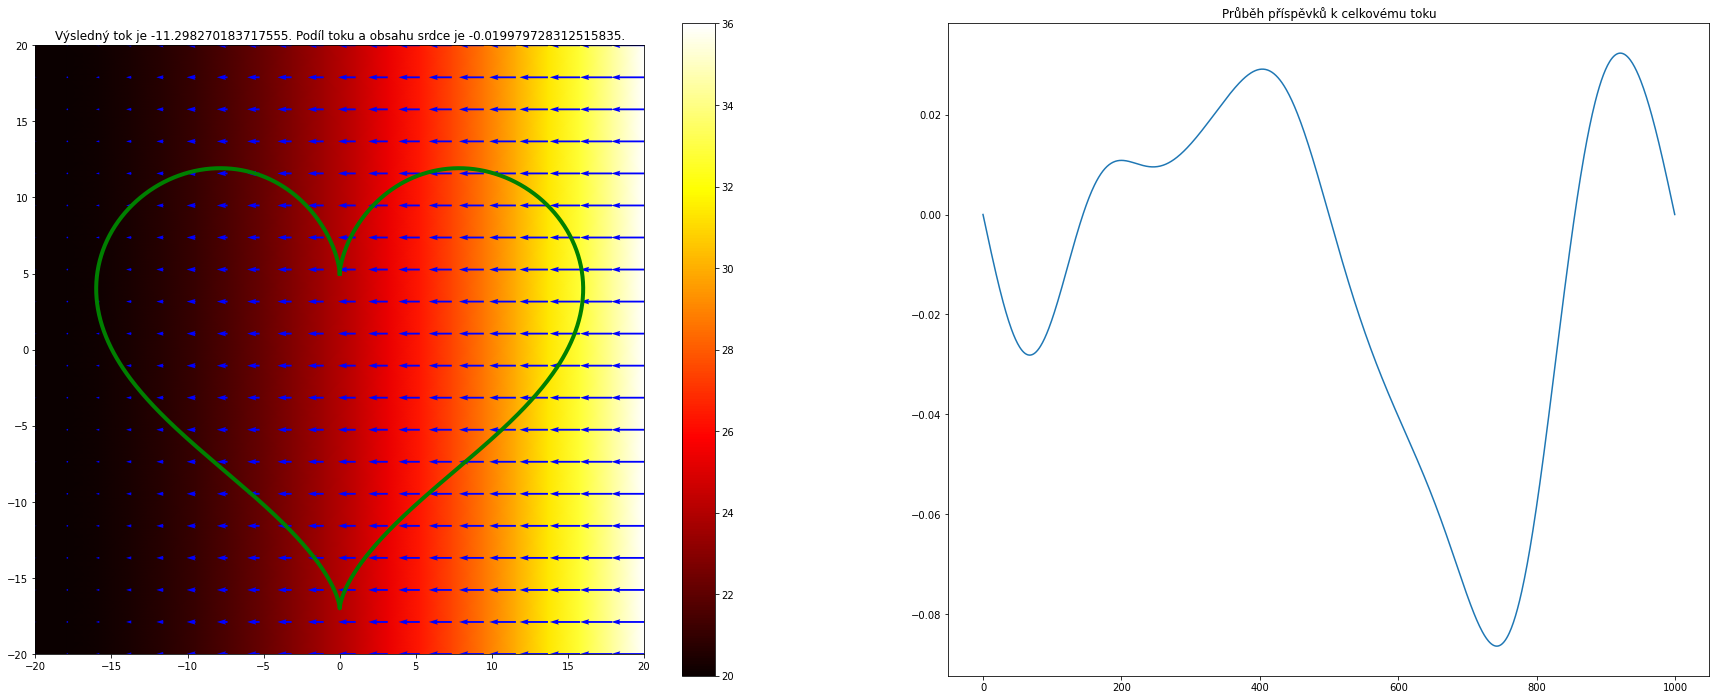

In [ ]:
def teplota (x,y): 
  return 20+0.01*(x+20)**2
KRESLI()  

Teplota na obrázku je dána vztahem $$ T=20+0.01(x+20)^2.$$ Roste tedy nelineárně směrem doprava (stále vyšší rychlostí). Tok v pravé části srdce je intenzivnější než tok v levé. Tok v pravé části je dovnitř a tedy záporný. Tok v levé části je kladný a malý. Celkový tok je tedy záporný. Divergence vektorového pole popisujícího tok tepla je konstantní a záporná, $$\nabla \cdot (-\nabla T)=-0.02.$$

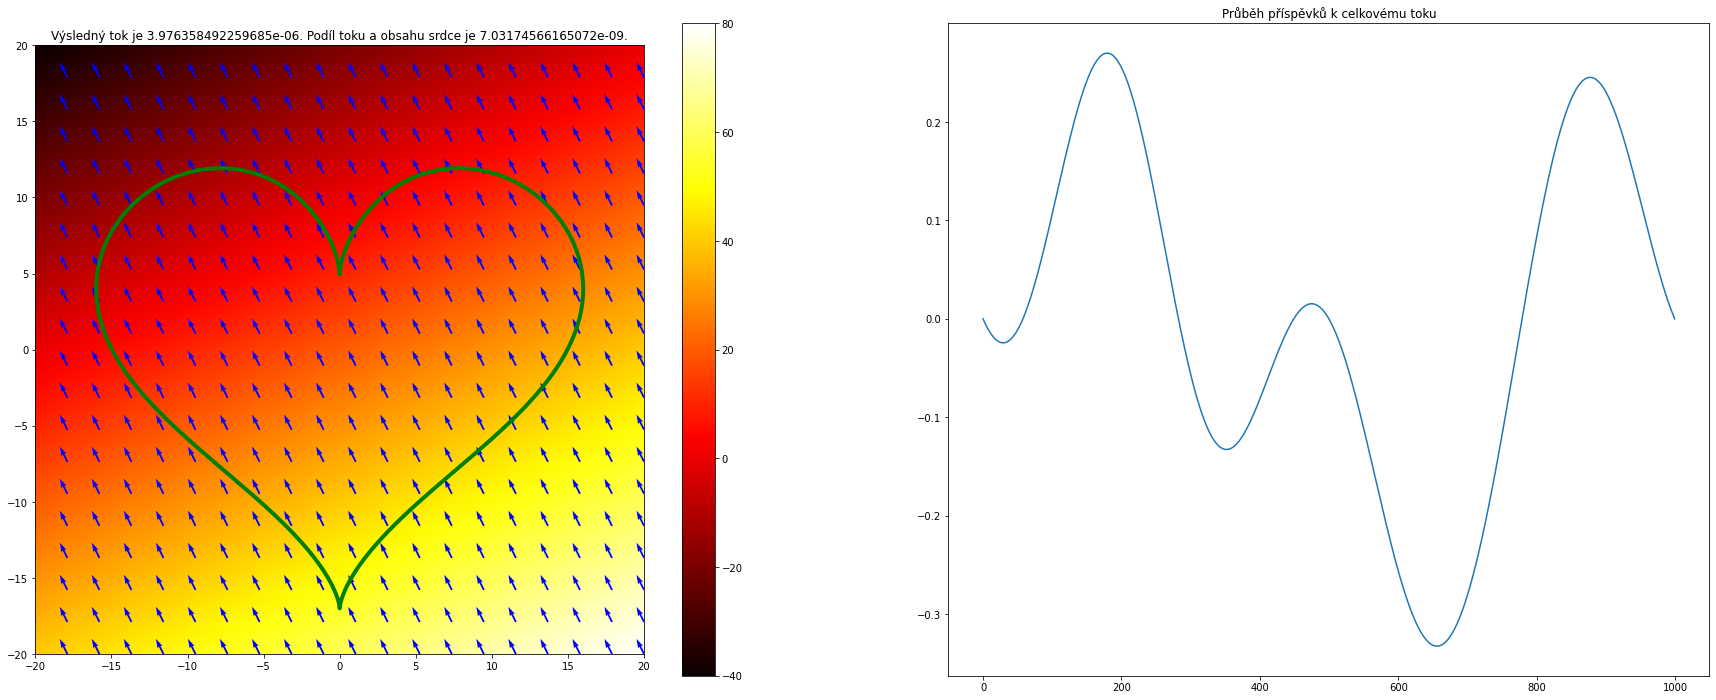

In [ ]:
def teplota (x,y): 
    return 20-2*y+x
KRESLI()    
  

Teplota je dána vztahem $$ T(x,y)=20+x-2y.$$ Roste tedy směrem dolů. Proto teplo teče z pravého dolního rohu do levého horního. Narozdíl od konstantního toku přecházejícího přes srdce zleva doprava již situace není symetrická. Protože však tok nikde nezesiluje ani nezeslabuje, je přirozené, že teplo které na jednom konci do srdce vteče na druhém vyteče. Celkový tok je tedy nulový. Divergence vektorového pole popisujícího tok tepla je nulová, $$\nabla \cdot (-\nabla T)=0.$$

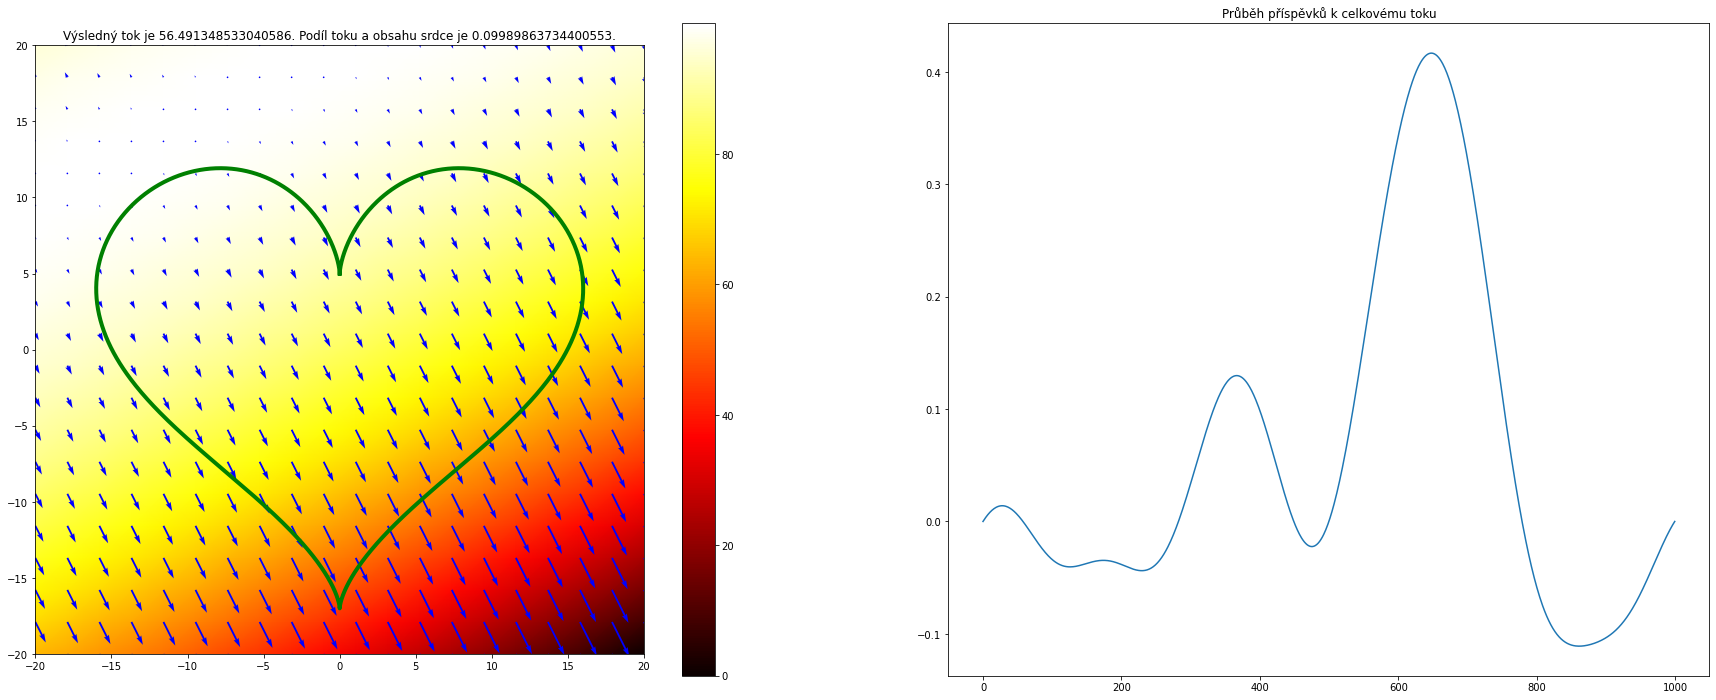

In [ ]:
def teplota (x,y): 
   return 100-0.01*(40+x-2*y)**2 
KRESLI()   

Teplota je dána vztahem  $$T(x,y)=100-0.01(40+x-2y)^2 $$
Teplo teče směrem doprava dolů. Vektory se postupně prodlužují a tok tedy nabývá na intenzitě. Tato intenzivnější část je v místě, kde teplo teče ven, tj. v místě, kde je tok kladný. Záporné příspěvky v levém horním rohu jsou zanedbatelné a celkový tok je kladný. Divergence vektorového pole popisujícího tok tepla je konstantní a kladná, platí $$\nabla \cdot (-\nabla T)=0.1.$$

# Tok s nekonstantní divergencí

V případě toku s konstantní divergencí jsme viděli, že podíl toku přes hranici a obsahu množiny byl numericky roven této divergenci. Toto je pochopitelné a plyne to z fyzikální interpretace pojmu divergence. V případě toku s nekonstantní divergencí máme v tomto podíle jakousi zprůměrovanou hodnotu. V jakém smyslu je zprůměrována si ukážeme v pasáži věnované *dvojnému integrálu*.

In [ ]:
h=0.01
def divergence_gradientu (x,y):
    global h     
    return (vyska(x+h,y) + vyska(x-h,y) + vyska(x,y+h) + vyska(x,y-h) - 4* vyska(x,y) ) / h**2

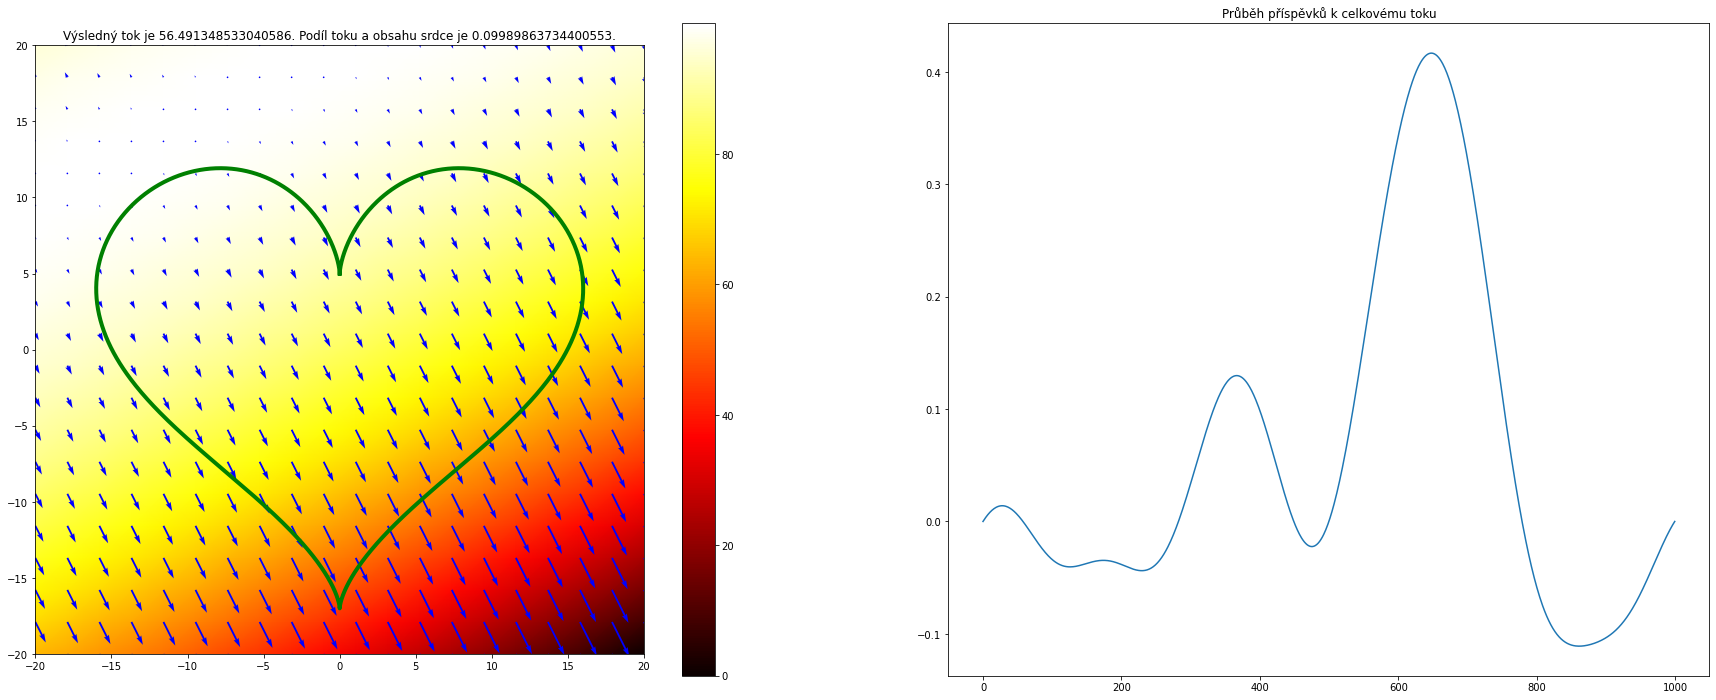

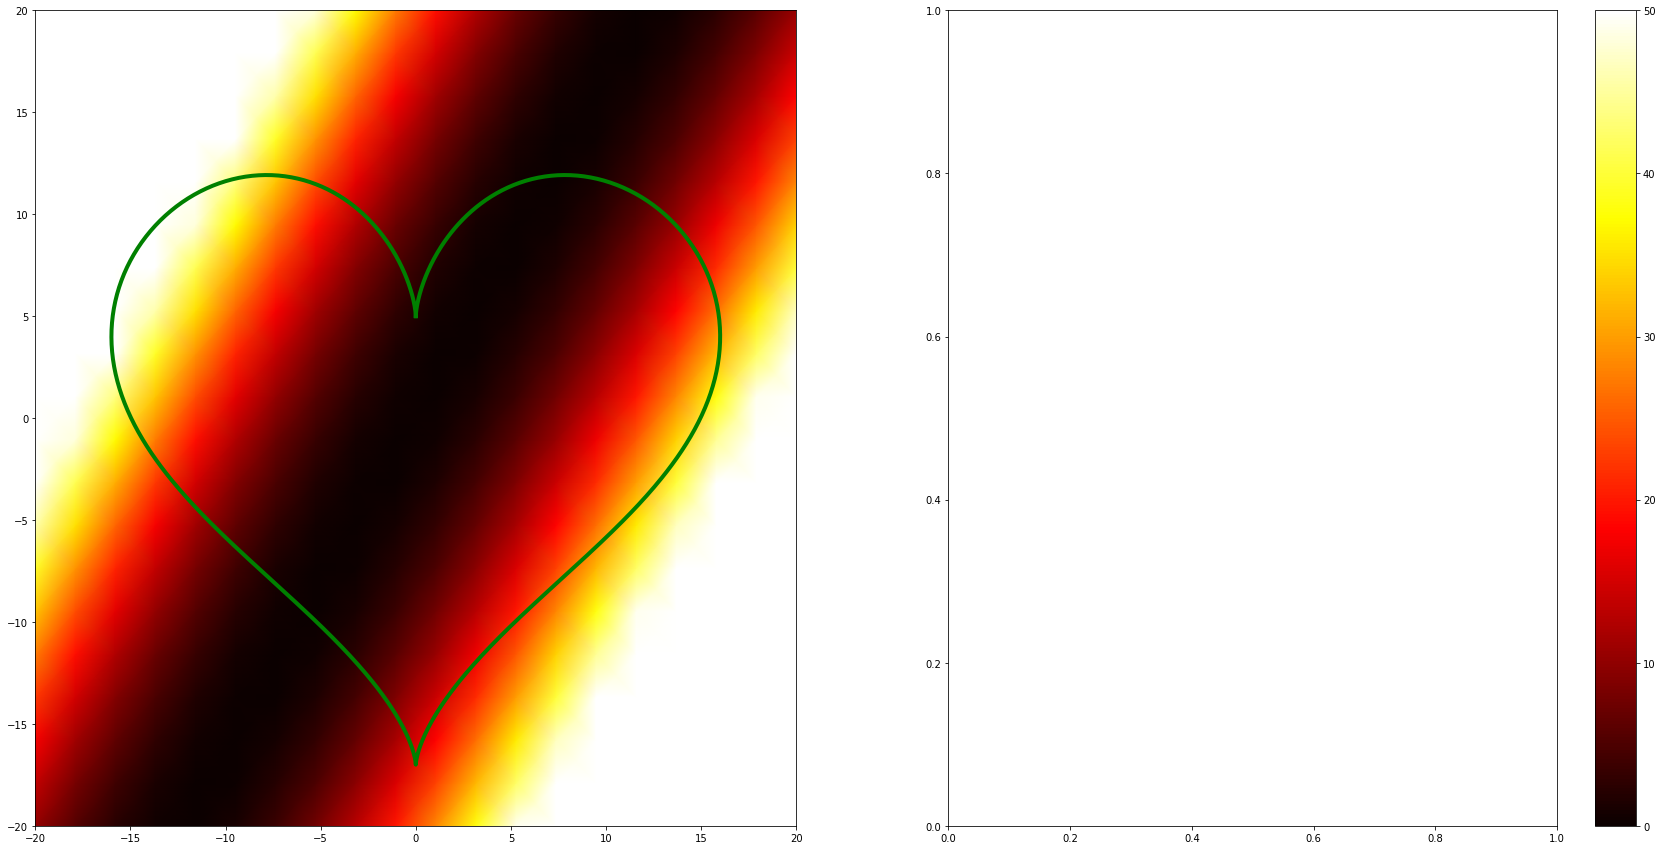

In [ ]:
def vyska (x,y): 
    return 20+0.01*(x-0.6*y+.1)**4
KRESLI()

y, x = numpy.mgrid[-20:20:20j, -20:20:20j]  # mrizka pro kresleni gradientu a barevne mapy funkce dvou promennych
z = divergence_gradientu(x, y) # evaluation of the function on the grid

# inicializace grafiky, dva grafy vedle sebe
fig, axes = plt.subplots(1, 2, figsize=(30,15))
ax=axes[0]  # začneme kreslit do prvního grafu
    
cmap = plt.get_cmap('hot')       # nastaveni schema pro barevnou mapu
output=ax.pcolormesh(x, y, z, cmap=cmap, shading='gouraud', vmax=50, vmin=0) # vykresleni barevne mapy
#output=ax.pcolormesh(x, y, z, cmap=cmap, shading='gouraud') # vykresleni barevne mapy
#ax.quiver(x, y, vx, vy, color='blue', lw=.01) # vykreslení toku
plt.colorbar(output) # barevny sloupec s hodnotami vedle grafu

N = 1000
t = numpy.linspace(0, 2*numpy.pi, N) # uzlove body krivky
dt = (t[-1] - t[0] ) / N # vzdalenost mezi uzlovymi body
ax.plot(krivka(t)[0],krivka(t)[1], color='green', lw=4) # vykresleni krivky


ax=axes[1]  # začneme kreslit do druhého grafu
#ax = plt.axes(projection='3d')
#surf = plt.plot_surface(x, z, z, cmap=cm.coolwarm,                        linewidth=0, antialiased=False)



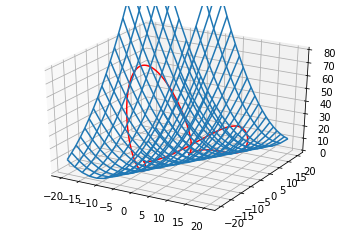

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

y, x = numpy.mgrid[-20:20:20j, -20:20:20j]    # mrizka pro kresleni gradientu a barevne mapy funkce dvou promennych
z = divergence_gradientu(x, y)                # evaluation of the function on the grid

# Plot the surface.
#surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.plot_wireframe(x, y, z)

# Customize the z axis.
ax.set_zlim(0, 80)

N = 1000                                      # počet dělení intervalu pro parametr t
t = numpy.linspace(0, 2*numpy.pi, N)          # uzlové body křivky
X, Y = krivka(t)
Z = divergence_gradientu(X,Y)
plt.plot(X,Y,Z, color='red')


